 # Customer Segmentation

Dataset Explanaion

The dataset is a CSV, where each row represents an sku which is a part of an order. The different columns are described below. 
InvoiceNo
A single invoice number represents one order that was placed. There might be multiple rows for the same invoice number, representing the different SKUs that were ordered.

StockCode:
This represents the sku for the particular item that was ordered.

Description:
This describes the exact item that was ordered in words.

Quantity:
The quantity of the specific sku that was ordered.

InvoiceDate:
This is the date the order was placed.

UnitPrice:
This is the price of the particular sku that was ordered.

CustomerID:
An anonymized ID of the customer who placed the order.


In [3]:
# import different modules`
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

Then, I load the data. Once done, I also give some basic informations on the content of the dataframe: the type of the various variables, the number of null values and their percentage with respect to the total number of entries:

Data Preparation

In [4]:
#loading the csv file
df=pd.read_csv('C:\\Users\\SHAHBAZ\\Desktop\\data science\\Busibud\\ml_tasks\\ml_task_1\\data.csv', encoding= 'unicode_escape')
print('The shape of the dataframe is :{}'.format(df.shape))

The shape of the dataframe is :(541909, 8)


In [5]:
#displaying the top 5 rows of dataframe
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
#display the columns
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
#calculating the total number of missing values in each column and its percentage
missing_data = pd.DataFrame({'total_missing': df.isnull().sum(), 'perc_missing': (df.isnull().sum()/541909 )*100})
missing_data

,total_missing,perc_missing
InvoiceNo,0,0.000000
StockCode,0,0.000000
Description,1454,0.268311
Quantity,0,0.000000
InvoiceDate,0,0.000000
UnitPrice,0,0.000000
CustomerID,135080,24.926694
Country,0,0.000000


While looking at the number of null values in the dataframe, it is interesting to note that 25% approximate of the entries are not assigned to a particular customer. With the data available, it is impossible to impute values for the user and these entries are thus useless for the current exercise. So I delete them from the dataframe:

In [9]:
# we can see that approximate 25% of values are missing particular Customer ID so we will drop them
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

In [10]:
#the final shape
df.shape

(406829, 8)

In [11]:
#calculating finally the total number of missing values in each column and its percentage
missing_data = pd.DataFrame({'total_missing': df.isnull().sum(), 'perc_missing': (df.isnull().sum()/406829 )*100})
missing_data

,total_missing,perc_missing
InvoiceNo,0,0.0
StockCode,0,0.0
Description,0,0.0
Quantity,0,0.0
InvoiceDate,0,0.0
UnitPrice,0,0.0
CustomerID,0,0.0
Country,0,0.0


OK, therefore, by removing these entries we end up with a dataframe filled at 100% for all variables! Finally, I check for duplicate entries and delete them:

In [12]:
#Now check for number of duplicate entries
print('Number of duplicate entries are: {}'.format(sum(df.duplicated())))

Number of duplicate entries are: 5225


In [13]:
country_cust_data=df[['Country','CustomerID']].drop_duplicates()
country_cust_data.groupby(['Country'])['CustomerID'].aggregate('count').sort_values(ascending=False)

Country
United Kingdom          3950
Germany                   95
France                    87
Spain                     31
Belgium                   25
Switzerland               21
Portugal                  19
Italy                     15
Finland                   12
Austria                   11
Norway                    10
Netherlands                9
Australia                  9
Denmark                    9
Channel Islands            9
Cyprus                     8
Sweden                     8
Japan                      8
Poland                     6
USA                        4
Canada                     4
Unspecified                4
Israel                     4
Greece                     4
EIRE                       3
Malta                      2
United Arab Emirates       2
Bahrain                    2
Czech Republic             1
Lithuania                  1
Lebanon                    1
RSA                        1
Saudi Arabia               1
Singapore                  1
Icelan

Here, I quickly look at the countries from which orders were made:We see that the dataset is largely dominated by orders made from the UK.

In [14]:
#consider only the UK
data=df.query("Country=='United Kingdom'").reset_index(drop=True)

In [15]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,15547.871368
std,263.129266,70.654731,1594.402590
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15514.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


In [16]:
#checking the minimum value of quantity
data.Quantity.min()
#since it is a negative value which is not possible since quantity cannot be negative 

-80995

In [17]:
#filter out all negative value of quantity
data = data[(data['Quantity'] > 0)]

In [18]:
#now check for Unit price column 
data.UnitPrice.min()

0.0

Column-wise analysis

In [19]:
print('Number of unique products are:{}'.format(len(data['StockCode'].value_counts())))
print('Number oftransactions are:{}'.format(len(data['InvoiceNo'].value_counts())))
print('Number of customers are:{}'.format(len(data['CustomerID'].value_counts())))

Number of unique products are:3645
Number oftransactions are:16649
Number of customers are:3921


It can be seen that the data concern 3921 users and that they bought 3645 different products. The total number of transactions carried out is 16649

 determine the number of products purchased in every transaction:

In [20]:
#Number of product purchased in each transaction and sorted according the customer ID and which ID purchase ones and ID continue the shopping
# the prefix C for the InvoiceNo variable: this indicates transactions that have been canceled
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
total_product= temp.rename(columns = {'InvoiceDate':' toal products per ID'})
# Sorting by column 'Country'
total_product.sort_values(by=['CustomerID'])

,CustomerID,InvoiceNo,toal products per ID
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
...,...,...,...
22177,18283.0,557956,87
22186,18283.0,580872,50
22188,18287.0,570715,38
22187,18287.0,554065,29


 I count the number of canceled orders:

In [21]:
#Lets calculate the number of canceled order
total_product['order_canceled'] = total_product['InvoiceNo'].str.contains('C', na=False).astype(int)
n1=total_product['order_canceled'].sum()
print('total number of cancel order are :{}'.format(n1))

total number of cancel order are :3654


In [22]:
total_product.columns

Index(['CustomerID', 'InvoiceNo', ' toal products per ID', 'order_canceled'], dtype='object')

In [23]:
#add new column of Total Price
data['TotalPrice'] = data['UnitPrice'] * data['Quantity']

In [24]:
data['TotalPrice']

0          15.30
1          20.34
2          22.00
3          20.34
4          20.34
           ...  
361873     23.40
361874     23.60
361875     30.00
361876    214.80
361877     70.80
Name: TotalPrice, Length: 354345, dtype: float64

# RFM Modelling
RFM analysis is a customer behavior segmentation technique. Based on customers' historical transactions, RFM analysis focuses on 3 main aspects of customers' transactions: recency, frequency and purchase amount. Understanding these behaviors will allow businesses to cluster different customers into groups.

RECENCY: How recently did the customer visit our website or how recently did a customer purchase?

Frequency: How often do they visit or how often do they purchase?

Monetary: How much revenue we get from their visit or how much do they spend when they purchase?

In [25]:
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])

In [26]:
data.InvoiceDate.max()

Timestamp('2011-12-09 12:49:00')

In [27]:
#since the last date of purchase was 2011-12-09 we will take consider the latest date as 2011-12-10
recent_date=dt.datetime(2011,12,10)

In [28]:
RMFscore=data.groupby('CustomerID').agg({'InvoiceDate':lambda x:(recent_date-x.max()).days,'InvoiceNo':lambda num:len(num),'TotalPrice':lambda price: price.sum()})
 #conerting InvoiceDate as int type
RMFscore['InvoiceDate']=RMFscore['InvoiceDate'].astype(int)
RMFscore.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalPrice':'Monetary'},inplace=True)

For Recency: Calculate the number of days between present date and date of last purchase each customer.

For Frequency: Calculate the number of orders for each customer.

For Monetary: Calculate sum of purchase price for each customer.

In [29]:
RMFscore.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34


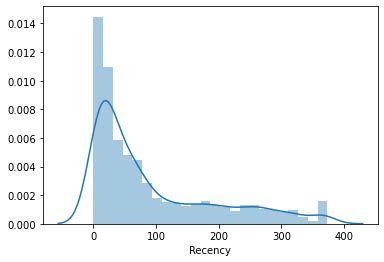

In [30]:
#plot the graph of Recency to see the distirbution of column
sns.distplot(RMFscore['Recency'])
#we can see that data is right skewed and we need to normalize it

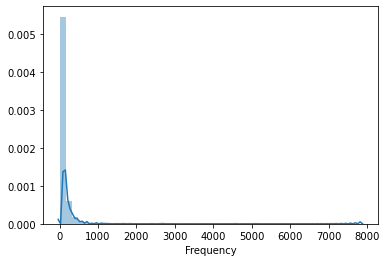

In [31]:
sns.distplot(RMFscore['Frequency'])

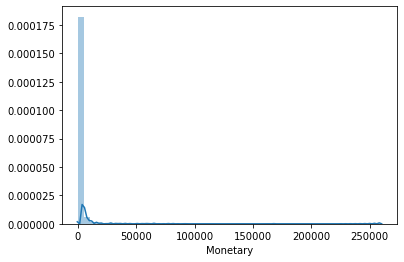

In [32]:
sns.distplot(RMFscore['Monetary'])

In [33]:
#split the RMFscore into segments of quartiles
quartiles=RMFscore.quantile(q=[0.25,0.50,0.75])
quartiles=quartiles.to_dict()
quartiles

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.0},
 'Monetary': {0.25: 300.03999999999996, 0.5: 651.8199999999999, 0.75: 1575.89}}

qcut() is Quantile-based discretization function. qcut bins the data based on sample quantiles.

In [34]:
RMFscore['r_quartile'] = pd.qcut(RMFscore['Recency'], 4, ['1','2','3','4'])
RMFscore['f_quartile'] = pd.qcut(RMFscore['Frequency'], 4, ['4','3','2','1'])
RMFscore['m_quartile'] = pd.qcut(RMFscore['Monetary'], 4, ['4','3','2','1'])

In [35]:
RMFscore.head()

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12747.0,2,103,4196.01,1,1,1
12748.0,0,4596,33719.73,1,1,1
12749.0,3,199,4090.88,1,1,1
12820.0,3,59,942.34,1,2,2


In [36]:
RMFscore['RFM_Score'] = RMFscore.r_quartile.astype(str)+ RMFscore.f_quartile.astype(str) + RMFscore.m_quartile.astype(str)
RMFscore.head()

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
12346.0,325,1,77183.60,4,4,1,441
12747.0,2,103,4196.01,1,1,1,111
12748.0,0,4596,33719.73,1,1,1,111
12749.0,3,199,4090.88,1,1,1,111
12820.0,3,59,942.34,1,2,2,122


Customers with the lowest recency, highest frequency and monetary amounts considered as top customers.

In [37]:
customer_cat=['Platinum','Gold','Silver','Bronze']
score=pd.qcut(RMFscore.RFM_Score.astype(float),q=4,labels=customer_cat)
RMFscore['RFM_customer_cat']=score.values
RMFscore.head()

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Score,RFM_customer_cat
CustomerID,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,Bronze
12747.0,2,103,4196.01,1,1,1,111,Platinum
12748.0,0,4596,33719.73,1,1,1,111,Platinum
12749.0,3,199,4090.88,1,1,1,111,Platinum
12820.0,3,59,942.34,1,2,2,122,Platinum


In [38]:
RMFscore[RMFscore['RFM_Score']=='311'].sort_values(by='Monetary').reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Score,RFM_customer_cat
0,16515.0,52,113,1627.13,3,1,1,311,Silver
1,15002.0,115,115,1641.76,3,1,1,311,Silver
2,14837.0,89,108,1649.50,3,1,1,311,Silver
3,17284.0,60,292,1652.58,3,1,1,311,Silver
4,15549.0,77,115,1693.26,3,1,1,311,Silver
5,12843.0,65,103,1702.26,3,1,1,311,Silver
6,15241.0,66,110,1756.44,3,1,1,311,Silver
7,15220.0,51,117,1778.96,3,1,1,311,Silver
8,13875.0,53,104,1786.79,3,1,1,311,Silver
9,18235.0,71,104,1796.48,3,1,1,311,Silver


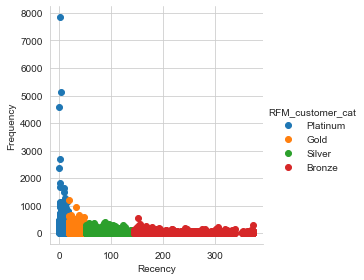

In [39]:
#plot between Recency vs Frequency
sns.set_style("whitegrid");
sns.FacetGrid(RMFscore, hue="RFM_customer_cat", size=4) \
   .map(plt.scatter, "Recency", "Frequency") \
   .add_legend();
plt.show();


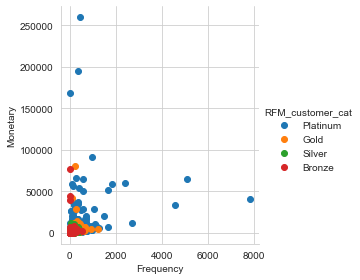

In [40]:
sns.set_style("whitegrid");
sns.FacetGrid(RMFscore, hue="RFM_customer_cat", size=4) \
   .map(plt.scatter, "Frequency", "Monetary") \
   .add_legend();
plt.show();

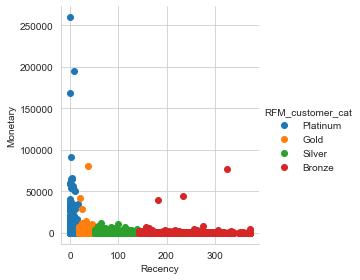

In [41]:
sns.set_style("whitegrid");
sns.FacetGrid(RMFscore, hue="RFM_customer_cat", size=4) \
   .map(plt.scatter, "Recency", "Monetary") \
   .add_legend();
plt.show();

# Kmeans

In [42]:
#handle the negative values
def handle_negative(num):
    if num<=0:
        return 1
    else:
        return num
RMFscore['Recency']=[handle_negative(x)for x in RMFscore.Recency]
RMFscore['Monetary']=[handle_negative(x)for x in RMFscore.Monetary]

In [43]:
x_data=RMFscore[['Recency','Monetary','Frequency']]
x_data.head()

,Recency,Monetary,Frequency
CustomerID,,,
12346.0,325,77183.60,1
12747.0,2,4196.01,103
12748.0,1,33719.73,4596
12749.0,3,4090.88,199
12820.0,3,942.34,59


In [44]:
#standardization of feature to bring them in 0,1 range
scaler=StandardScaler()
scaler_data=scaler.fit_transform(x_data)
scaler_data=pd.DataFrame(scaler_data,index=RMFscore.index,columns=x_data.columns)

In [45]:
#function for getting the best number of cluster withoput taking any random guesses
squared_dist={}
for n_clusters in list(range(1,10)):
    KM= KMeans(n_clusters=n_clusters, init = "k-means++",max_iter=1000)
    KM=KM.fit(scaler_data)
    squared_dist[n_clusters]=KM.inertia_

Text(0.5, 1.0, 'Elbow Method')

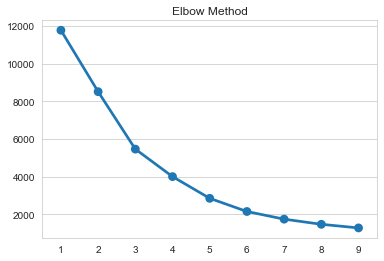

In [46]:
#The Elbow Method is one of the most popular methods to determine this optimal value of k.
sns.pointplot(x=list(squared_dist.keys()),y=list(squared_dist.values()))
plt.title('Elbow Method')
#take number of cluster as 3

In [47]:
#build kmeans clustering model
KM_clust=KMeans(n_clusters=4, init = "k-means++",max_iter=1000)
KM_clust.fit(scaler_data)
RMFscore['cluster']=KM_clust.labels_
RMFscore.head()

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Score,RFM_customer_cat,cluster
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,Bronze,2
12747.0,2,103,4196.01,1,1,1,111,Platinum,1
12748.0,1,4596,33719.73,1,1,1,111,Platinum,3
12749.0,3,199,4090.88,1,1,1,111,Platinum,1
12820.0,3,59,942.34,1,2,2,122,Platinum,1


# Conclusion
The models created are not 100% effective you must prepare and plan for the various challenges and hurdles that each step may present, and always make sure to adapt your process to any new information or feedback that might change its output.
Additionally, you cannot force feed this process on your business. If the key stakeholders that will be impacted by the best current customers segmentation process do not fully buy-in, then the outputs produced from it will be relatively meaningless.